# **Chapter 4: The Great Embeddings Bake-Off**
In the past three chapters, we have demonstrated 5 ways to embed peptide sequences into a numeric representation.

1.   Single-number embeddings with pI
2.   Fractional amino acid composition
3.   One-hot encoding
4.   Atomic composition
5.   Learned embeddings with ESM

These five methods were increasingly complex, and so you might be asking, "was it worth it?". The best way to answer this question is by benchmarking them.


---
## **Using this Tutorial**

This tutorial is designed to be interactive, and you are encouraged to change the code and explore. To do this, you'll need to save a copy of this so that you have editing permissions. Use `File->Save a copy in Drive` to make an editable copy for yourself. Colab notebooks consist of text cells (like this one) and code cells. You interact with the notebook by executing (running) the code cells by clicking the "play button" in each cell. You can also run all cells at once by using `Runtime->Run all`.

*Note*: This notebook is computationally heavy and requires the use of a GPU. In Colab go to `Runtime` → `Change runtime type` → `T4 GPU`

##Evaluating Performance
In this notebook we will be comparing the different methods of embedding against a specific machine learning task - predicting peptide retention time. Please keep in mind that this is not the only ML task that we can do with peptides - there are many! We are simply choosing this one because it is intuitive and easy to demonstrate.

In the code below, you will see a couple of things. First, we'll get the code for each of the five methods (a repeat of what you saw in the earlier chapters). Then we will get the peptide retention time data and format that prior to training. Finally, we will create a neural network that can take as input any of the five embeddings that we can make. Each model will be trained on a portion of our data and then tested against the remaining (held-out) subset of the data.

We are using a relatively small dataset here for training and evaluation - because it can fit into this notebook and runs in a reasonable time. It is true that we could use more data and get some extra performance out of the models. But our current dataset is enough to convey the main message - embeddings matter! For this prediction task, you can get improved performance with an advanced embedding.

## Section 1 - Code for embeddings
In this section is code for embeddings. You can look at it if you want, but it's the same thing you saw in previous chapters.


**Previous embedding methods- code**

If you take the time to look through here, you'll see that there are a *few* changes to each function, but they contain essentially the same logic

In [ ]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY"

import numpy as np
import pandas as pd

def array_encode_peptide(peptide, amino_acids=amino_acids):
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    encoded_matrix = np.zeros(len(aa_to_index))
    for aa in peptide:
        if aa in aa_to_index:
            encoded_matrix[aa_to_index[aa]] += 1
    # Normalize by max count
    max_count = encoded_matrix.max()
    if max_count != 0:
        encoded_matrix = encoded_matrix / max_count
    return encoded_matrix

def one_hot_encode(sequence, amino_acids=amino_acids):
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    one_hot = np.zeros((len(sequence), len(amino_acids)), dtype=int)
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            one_hot[i, aa_to_index[aa]] = 1
    return one_hot

# array_encode_peptide('SAMPLER')
# one_hot_encode('SAMPLER')

### Atomic Acid Composition

In [ ]:
# @title Helper Regex and Plotting functions

"""
These are some Regex functions that I used to split up the peptides into their
amino acids and modifications. They work for the specific examples that I gave,
but each Mass Spectrometry output file may have its own prefered methods of
representing modifications.
"""

import matplotlib.pyplot as plt
import pprint
import re

def check_PTMs(aa):
    delimiters = ['[', ']', '(', ')']
    # Create a regex pattern from the list of delimiters
    pattern = '|'.join(map(re.escape, delimiters))
    # Split the string using the pattern
    return re.split(pattern, aa)

def remove_PTM(string):
    # This removes PTMs and returns only the amino acids
    result = []
    inside_brackets = False

    for char in string:
        if char == '[':
            inside_brackets = True
        elif char == ']':
            inside_brackets = False
        elif not inside_brackets:
            result.append(char)

    return ''.join(result)

def break_into_aa(string):
    # This groups PTMs onto the AA
    result = []
    temp = ""
    inside_brackets = False

    for char in string:
        if char == '[':
            inside_brackets = True
            temp += char
        elif char == ']':
            inside_brackets = False
            temp += char
            result[-1] += temp
            temp = ""
        elif inside_brackets:
            temp += char
        else:
            result.append(char)
    return result

def plot_heatmap_subplots(embedding_dict):
    """
    Takes the dictionary returned by deepLC_embedding() and
    plots each of the four embeddings as a heatmap in a 2x2 grid of subplots.
    """
    # Subplot formatting
    items = sorted(embedding_dict.items(), key=lambda x: x[0])
    fig, axes = plt.subplots(nrows=2, ncols=2)
    axes = axes.flat
    dynamic_fontsize = max(10, fig.get_figheight() * 1.5)

    # Plot each embedding in its own subplot
    for (name, matrix), ax in zip(items, axes):
        data = np.array(matrix)

        # If it's 1D, reshape to (1, -1) so imshow can display it
        if data.ndim == 1:
            data = data.reshape(1, -1)

        # Display the heatmap
        img = ax.imshow(data, aspect='auto', cmap='viridis')
        ax.set_title(f"{name}, shape={data.shape}", fontsize = dynamic_fontsize)

        # Add a colorbar for each subplot
        plt.colorbar(img, ax=ax)
        plt.subplots_adjust(hspace=0.5, wspace=0.25)

    plt.show()

In [ ]:
# @title Definitions

import numpy as np
AMINO_ACID_ATOMIC_COMP = {
    # Standard amino acids atomic composition for
    #             (C,  H, N, O, P, S).
    'A': np.array([3,  7, 1, 2, 0, 0]),  # Ala
    'C': np.array([3,  7, 1, 2, 0, 1]),  # Cys
    'D': np.array([4,  7, 1, 4, 0, 0]),  # Asp
    'E': np.array([5,  9, 1, 4, 0, 0]),  # Glu
    'F': np.array([9, 11, 1, 2, 0, 0]),  # Phe
    'G': np.array([2,  5, 1, 2, 0, 0]),  # Gly
    'H': np.array([6,  9, 3, 2, 0, 0]),  # His
    'I': np.array([6, 13, 1, 2, 0, 0]),  # Ile
    'K': np.array([6, 14, 2, 2, 0, 0]),  # Lys
    'L': np.array([6, 13, 1, 2, 0, 0]),  # Leu
    'M': np.array([5, 11, 1, 2, 0, 1]),  # Met
    'N': np.array([4,  8, 2, 3, 0, 0]),  # Asn
    'P': np.array([5,  9, 1, 2, 0, 0]),  # Pro
    'Q': np.array([5, 10, 2, 3, 0, 0]),  # Gln
    'R': np.array([6, 14, 4, 2, 0, 0]),  # Arg
    'S': np.array([3,  7, 1, 3, 0, 0]),  # Ser
    'T': np.array([4,  9, 1, 3, 0, 0]),  # Thr
    'V': np.array([5, 11, 1, 2, 0, 0]),  # Val
    'W': np.array([11,12, 2, 2, 0, 0]),  # Trp
    'Y': np.array([9, 11, 1, 3, 0, 0]),  # Tyr
    'X': np.array([0,  0, 0, 0, 0, 0])   # For padding or unknown; all zeros
}

# Although there are many PTMs, I'm just including a few as example
MODIFICATIONS = {
    'Oxidation':            np.array([0, 0, 0, 1, 0, 0]), # This adds 1 'Oxygen'
    'Phosphorylation':      np.array([0, 1, 0, 3, 1, 0]),
    'Carbamidomethylation': np.array([2, 3, 1, 1, 0, 0]),
    'Deamidation':          np.array([0, -1, -1, 1, 0, 0]), # This removes H, N, and adds an O
    'Acetylation':          np.array([2, 2, 0, 1, 0, 0]),
    'Methylation':          np.array([1, 2, 0, 0, 0, 0])
}

In [ ]:
# @title Embedding 1: Amino acid composition matrix

def get_atomic_composition(aa):
    """
    This is a helper function that takes in an amino acid
    (M, M[Oxidation], etc.)
    and returns its atomic composition.
    """
    split_result = check_PTMs(aa)
    atom_count = np.array([0, 0, 0, 0, 0, 0]) # Initialize atom counts at 0
    for item in split_result:
        if item in AMINO_ACID_ATOMIC_COMP:
            atom_count += AMINO_ACID_ATOMIC_COMP[item]
        elif item in MODIFICATIONS:
            atom_count += MODIFICATIONS[item]
    return atom_count

# print('M:            ' + str(get_atomic_composition('M')))
# print('M[Oxidation]: '+ str(get_atomic_composition('M[Oxidation]')))

def build_aa_composition_matrix(peptide, max_len=60):
    """
    Builds a 60×6 matrix, where each row corresponds to the atomic composition
    of one amino acid in the peptide. If peptide < 60, pad with zeros.
    """
    comp_matrix = np.zeros((max_len, 6)) # 1 columns for each atom in C, H, N, O, P, S
    for i in range(min(len(peptide), max_len)):
        aa = peptide[i]
        comp_matrix[i] = get_atomic_composition(aa)
    return comp_matrix

# print('SAMPLER: \n' + str(build_aa_composition_matrix("SAMPLER")[:8]))

In [ ]:
# @title Embedding 2: Di-amino acid matrix
def build_diamino_acid_matrix(peptide, max_pairs=30):
    """
    Builds a 30×6 matrix, where each row corresponds to the sum of atomic
    composition of two adjacent amino acids (non-overlapping).
    If the peptide has odd length, the last AA will be paired with a zero padding.
    If #pairs < 30, pad the matrix with zeros.
    """
    di_aa_matrix = np.zeros((max_pairs, 6))

    # Split into di-amino acid chunks (non-overlapping)
    pairs = []
    for i in range(0, len(peptide), 2):
        first_aa = peptide[i]
        if i+1 < len(peptide):
            second_aa = peptide[i+1]
        else:
            second_aa = 'X'  # or just treat as zero
        pair_comp = get_atomic_composition(first_aa) + get_atomic_composition(second_aa) # <-- Borrowed function from first embedding
        pairs.append(pair_comp)

    # Fill up the matrix
    for i in range(min(len(pairs), max_pairs)):
        di_aa_matrix[i] = pairs[i]

    return di_aa_matrix

# print(build_diamino_acid_matrix('SAMPLER'))

In [ ]:
# @title Embedding 3: One-hot matrix
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids

# Map One-hot index mapping for the 20 standard amino acids:
AMINO_ACID_INDEX = {aa: i for i, aa in enumerate(amino_acids)}

def get_one_hot_encoding(aa):
    vec = np.zeros(20)
    if aa in AMINO_ACID_INDEX:
        idx = AMINO_ACID_INDEX[aa]
        vec[idx] = 1.0
    return vec

def build_one_hot_matrix(peptide, max_len=60):
    """
    Builds a 60×20 matrix, where each row is one-hot for the corresponding
    amino acid. If < 60, pad with zeros.
    """
    one_hot_matrix = np.zeros((max_len, 20))
    for i in range(min(len(peptide), max_len)):
        aa = remove_PTM(peptide[i]) # Calls a regex function to remove PTM
        one_hot_matrix[i] = get_one_hot_encoding(aa)
    return one_hot_matrix

# print('  '+'  '.join([aa for aa in amino_acids]))
# print(build_one_hot_matrix(break_into_aa('SAM[OXIDATION]PLER'))[:8])

In [ ]:
# @title Embedding 4: Global Features
def build_global_features(peptide):
    """
    Build the 55-dimensional global feature vector:
    [ length(1), total_comp(6),
      first4_comp(4*6=24), last4_comp(4*6=24) ]
    """
    # 1) length
    length_feat = len(peptide)

    # 2) total atomic composition
    total_comp = np.zeros(6)
    for aa in peptide:
        total_comp += get_atomic_composition(aa)

    # 3) first four residues
    first4_comp = np.zeros(24)
    for i in range(min(4, len(peptide))):
        first4_comp[i*6:(i+1)*6] = get_atomic_composition(peptide[i])

    # 4) last four residues
    last4_comp = np.zeros(24)
    for i in range(1, min(4, len(peptide))+1):
        # Fill from the end of 'peptide'
        aa = peptide[-i]
        idx = (4 - i) * 6
        last4_comp[idx:idx+6] = get_atomic_composition(aa)

    # Combine all into a 55-D vector
    global_feats = np.concatenate((
        np.array([length_feat]),
        total_comp,
        first4_comp,
        last4_comp
    ))

    return global_feats

# print(build_global_features('SAMPLER'))

In [ ]:
# @title Main Function
def deepLC_embedding(peptide, max_len = 60):
    """
    Given a peptide sequence, it will produce the 4 embeddings:
      1) amino_acid_comp:  (60, 6)
      2) diamino_acid_comp: (30, 6)
      3) one_hot:          (60, 20)
      4) global_features:     (55, )  (1D vector of length 55)
    """
    peptide = break_into_aa(peptide)

    aa_comp = build_aa_composition_matrix(peptide, max_len)
    di_aa_comp = build_diamino_acid_matrix(peptide, max_pairs=round(max_len/2))
    one_hot = build_one_hot_matrix(peptide, max_len)
    global_feats = build_global_features(peptide)

    # Return a dictionary with each path
    return {
        'aa_composition': aa_comp,
        'di_aa_composition': di_aa_comp,
        'one_hot': one_hot,
        'global_feats': global_feats
    }

### ESM

In [ ]:
# This is a more skin and bones version of the example from last chapter
%%capture
!pip install fair-esm
import torch
import esm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Initialize ESM model on GPU
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()

def esm_embedding(sequence):
    """Get ESM2 averaged residue embeddings (GPU-optimized)"""
    data = [("protein", sequence)]
    _, _, tokens = batch_converter(data)
    tokens = tokens.to(device)  # Move to GPU

    with torch.no_grad():
        results = model(tokens, repr_layers=[33])

    # Move back to CPU for numpy conversion
    return results["representations"][33].mean(dim=1).squeeze().cpu().numpy()

## Section 2 - Getting the Data
In this section, we are downloading and formatting the data. You can browse the code if you want. We'll be borrowing some data from our friends at [proteomicsML](https://proteomicsml.org/). Trying to get a set of peptides and their retention time. Here we are only getting a modest amount of data. Retention time prediction is notoriously hard because of batch effects between MS runs. So for the purpose of this notebook, we're going to avoid all that and get this data set from the proteomicsML people and trust that it is good to go.

In [ ]:
# @title Download and Prepare the Dataset
# 1. Download dataset
import pandas as pd
df = pd.read_csv("https://github.com/ProteomicsML/ProteomicsML/blob/main/datasets/retentiontime/PXD028248/PXD028248_evidence_selected_columns.zip?raw=true",
                 compression="zip", low_memory=False)
df.fillna(0.0, inplace=True)
target_raw_file = "20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_528"
df = df[df["Raw file"] == target_raw_file]
# filter where Modifications = Unmodified
df = df[df["Modifications"]=="Unmodified"]
# get rid of peptides with PEP >= .001 (high error)
df = df[df["PEP"] <= .001]

# Note that this is extremely basic data cleansing.
# In reality, we would likely do some more cleaning,
# however this is sufficient for the tutorial.

## Section 3 - Do the embeddings
In this section we will be running the training data through the embeddings. the ESM model is quite large, so note that this may take 2-3 minutes.


In [ ]:
# @title perform embeddings

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

!pip install pyteomics --quiet
!pip install peptides --quiet
import peptides
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import esm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn




# 1. Define embedding methods -------------------------------------------------


def relevant_embedding_method(sequence, method_name):
    if method_name == 'pI':
        return np.array([peptides.Peptide(sequence).isoelectric_point("EMBOSS")])
    elif method_name == 'AAC':
        return array_encode_peptide(sequence)
    elif method_name == 'One-Hot':
        return one_hot_encode(sequence)
    elif method_name == 'Atomic':
        return deepLC_embedding(sequence, 60)
    elif method_name == 'ESM':
        return esm_embedding(sequence)
    else:
        raise ValueError(f"Unknown method: {method_name}")

# 2. Preprocess embeddings ----------------------------------------------------
methods = ['pI', 'AAC', 'One-Hot', 'Atomic', 'ESM']

y = df['Retention time'].values
X = {method: [] for method in methods}


from tqdm import tqdm

##should I bother with this? It saves time if they were to rerun, or upload a different doc...
# Initialize embedding_cache only if it doesn't already exist-- so we don't have
# to run it from scratch every time we run the cell more than once per session.
if 'embedding_cache' not in globals():
    embedding_cache = {method: {} for method in methods}
else:
    # Make sure all methods are in the cache (in case methods list was updated)
    for method in methods:
        if method not in embedding_cache:
            embedding_cache[method] = {}


# Embedding processing loop with caching so we don't recompute an embedding
for method in methods:
    for count, seq in enumerate(tqdm(df['Sequence'], desc=f"{method}:"), start=1):
        if seq in embedding_cache[method]:
            # If sequence already processed, use cached embedding
            X[method].append(embedding_cache[method][seq])
        else:
            # Otherwise, compute the embedding and store it
            embedding = relevant_embedding_method(seq, method)
            embedding_cache[method][seq] = embedding
            X[method].append(embedding)

Using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 4.4 MB/s eta 0:00:00


ESM:: 100%|██████████| 7383/7383 [02:55<00:00, 42.01it/s]


In [ ]:
"""Because we have a bunch of different embedding methods that we want to compare
with eachother, the only fair way to do this would be to be consistent with
the ML architecture, thus we need to make the embeddings all have the same shape.
To do this, we will just flatten each of the embeddings to be 1 dimensional."""

# turn into np arrays and make them same shape
import copy
X_1 = copy.deepcopy(X) # Just in case you don't want to do the embeddings again.

for method in methods:
    # 1. Find the dimensions
    first_emb = X_1[method][0]
    print(f"\n{method} embedding inspection:")
    print(f"First embedding type: {type(first_emb)}")
    print(f"First embedding shape: {first_emb.shape if hasattr(first_emb, 'shape') else 'N/A'}")

    # 2. Standardize dimensions
    if method == 'One-Hot':
        # Flatten 2D one-hot matrices to 1D vectors
        X_1[method] = [emb.flatten() for emb in X_1[method]]

        # Pad/Crop to fixed length (60 * 20 = 1200D)
        fixed_length = 1200
        X_1[method] = [emb[:fixed_length] if len(emb) > fixed_length else
                     np.pad(emb, (0, fixed_length - len(emb)))
                     for emb in X_1[method]]


    elif method == 'Atomic':
        # Convert dictionary to numpy array
        processed = []
        target_length = None  # Will determine from first embedding

        for i, emb_dict in enumerate(X_1[method]):
            # Flatten and concatenate all components
            emb_array = np.concatenate([
                emb_dict['aa_composition'].flatten(),
                emb_dict['di_aa_composition'].flatten(),
                emb_dict['one_hot'].flatten(),
                emb_dict['global_feats'].flatten()
            ])

            # Set target length from first embedding
            if target_length is None:
                target_length = len(emb_array)
                print(f"Atomic embedding target length: {target_length}")

            # Verify consistency
            if len(emb_array) != target_length:
                raise ValueError(f"Atomic embedding at index {i} has length {len(emb_array)}, expected {target_length}")

            processed.append(emb_array)

        X_1[method] = processed

    elif method == 'ESM':
        # Ensure all ESM embeddings are 1D
        X_1[method] = [emb.reshape(-1) for emb in X_1[method]]

    # 3. Convert to numpy array
    try:
        X_1[method] = np.array(X_1[method])
        print(f"Success: {method} → {X_1[method].shape}")
    except Exception as e:
        print(f"Failed to convert {method}: {str(e)}")
        print("Sample problematic embeddings:")
        for i, emb in enumerate(X_1[method][:5]):
            print(f"Index {i}: Type={type(emb)}, Shape={emb.shape if hasattr(emb, 'shape') else 'N/A'}")


pI embedding inspection:
First embedding type: <class 'numpy.ndarray'>
First embedding shape: (1,)
Success: pI → (7383, 1)

AAC embedding inspection:
First embedding type: <class 'numpy.ndarray'>
First embedding shape: (20,)
Success: AAC → (7383, 20)

One-Hot embedding inspection:
First embedding type: <class 'numpy.ndarray'>
First embedding shape: (15, 20)
Success: One-Hot → (7383, 1200)

Atomic embedding inspection:
First embedding type: <class 'dict'>
First embedding shape: N/A
Atomic embedding target length: 1795
Success: Atomic → (7383, 1795)

ESM embedding inspection:
First embedding type: <class 'numpy.ndarray'>
First embedding shape: (1280,)
Success: ESM → (7383, 1280)


## Section 4 - Predict Retention Time
In this section we will define the architecture of a simple deep net for RT prediction, feed the embeddings to the model, and see how each embedding affects the results.


This is the model architecture we will use to demonstrate the differences between embeddings. It consists of 3 fully connected layers with ReLU activation between layers. The output is a single digit predicting the RT.

As you can deduce, this model is fairly simple and not complex enough to learn the intricacies of mass spectrometry and retention time. We are not trying to solve for RT; we are comparing the different embeddings and retention time is a good way to show this.

In [ ]:
# ====================== MODEL ARCHITECTURE ======================
class RTpredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)  # Move to GPU during initialization

    def forward(self, x):
        return self.net(x)


The following code block instantiates a clean version of the RTpredictor model and performs 50 epochs of training per embedding method. We save the metrics of each of the methods every epoch.

For some of the methods, the input embedding has to be flattened to fit into the model. This can cause some loss of information, especially for tensor embeddings where the information is saved in more than 2 dimensions.

In [ ]:
# =============================================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import time
import pandas as pd
from matplotlib.ticker import MaxNLocator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RTpredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

results = {}
loss_curves = {}
time_tracker = {}

for method in methods:
    print(f'\n=== Training {method} ===')
    start_time = time.time()

    # Data preparation
    X_method = X_1[method]
    X_train, X_test, y_train, y_test = train_test_split(
        X_method, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42
    )

    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_np = y_test

    # Model setup
    model = RTpredictor(X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training storage
    train_losses = []
    val_losses = []

    # Training loop
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=1024, shuffle=True)

    for epoch in range(50):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_t)
            val_loss = criterion(val_preds, y_val_t)

        train_losses.append(epoch_loss/len(train_loader))
        val_losses.append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1:3d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')

    # Store results
    loss_curves[method] = (train_losses, val_losses)
    time_tracker[method] = time.time() - start_time

    # Final predictions
    with torch.no_grad():
        test_preds = model(X_test_t).cpu().numpy().flatten()

    results[method] = {
        'test_mse': mean_squared_error(y_test_np, test_preds),
        'test_r2': r2_score(y_test_np, test_preds),
        'predictions': test_preds,
        'true_values': y_test_np,
        'embeddings': X_train.shape[1]
    }
    torch.cuda.empty_cache()




=== Training pI ===
Epoch  10 | Train Loss: 2917.2296 | Val Loss: 2855.3318
Epoch  20 | Train Loss: 1180.6079 | Val Loss: 1213.7952
Epoch  30 | Train Loss: 1142.9907 | Val Loss: 1198.9438
Epoch  40 | Train Loss: 1125.0518 | Val Loss: 1182.7434
Epoch  50 | Train Loss: 1114.2465 | Val Loss: 1173.0299

=== Training AAC ===
Epoch  10 | Train Loss: 2380.6385 | Val Loss: 2245.2981
Epoch  20 | Train Loss: 702.2152 | Val Loss: 646.1534
Epoch  30 | Train Loss: 532.5143 | Val Loss: 506.2289
Epoch  40 | Train Loss: 461.3654 | Val Loss: 451.2148
Epoch  50 | Train Loss: 423.5539 | Val Loss: 422.8383

=== Training One-Hot ===
Epoch  10 | Train Loss: 828.9737 | Val Loss: 725.6700
Epoch  20 | Train Loss: 88.8180 | Val Loss: 180.9181
Epoch  30 | Train Loss: 48.7768 | Val Loss: 140.0720
Epoch  40 | Train Loss: 36.0989 | Val Loss: 127.4914
Epoch  50 | Train Loss: 29.2827 | Val Loss: 121.2735

=== Training Atomic ===
Epoch  10 | Train Loss: 358.8310 | Val Loss: 311.4870
Epoch  20 | Train Loss: 93.0852 | 

## Section 5 - Visualizing The Results

In this section, we'll see how each embedding method did. Does it learn something useful about predicting retention time given a peptide sequence? We have several different plots, each describing the learning result in a slightly different way.


**Plot 1: Training loss**

In this plot, we can see the loss (error) as the model interative learns more through each round of training. After each epoch of training (one time through the training data), we can measure the accuracy of prediction. It is important to do this for both the training data and the validation data.  

This type of plot is common in machine learning. Here are a few things to look for:
1. The loss (error) goes down over time. A high loss means that the model's predictions are not good, a low loss means the opposite. If the model's loss goes down during the training, then it is learning.

2. We have plotted the loss on both the training and validation data (training data with a solid line, validation data with a dashed line). These are different things. The training data is seen by the model and so it directly learns these datapoints. The validation data is held back and the model does not get to learn about them.

3. Because the model can learn about the training data, it may eventually start to memorize answers for these data. That is called over-fitting and it is bad. Well, it means that the apparent improvement is not going to be generalizable to a new dataset. So look for the place where the training and validation results diverge (solid versus dashed lines).  

3. When the loss plateaus, it signifies that the model has learned as much as it can learn. We evaluate this using the validation data.

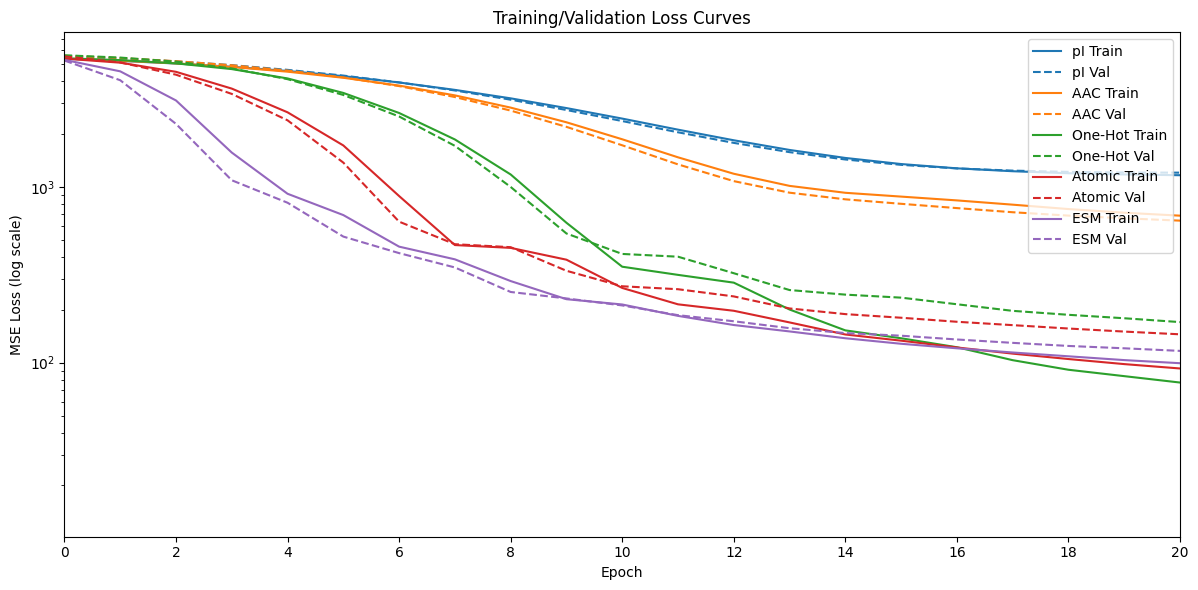

In [ ]:
# Cell 2: Visualization Code
# =============================================================================
# Learning Curves

plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for method, color in zip(methods, colors):
    train_loss, val_loss = loss_curves[method]
    train_loss = train_loss#[:21]
    val_loss = val_loss#[:21]
    plt.plot(train_loss, label=f'{method} Train', color=color)
    plt.plot(val_loss, '--', label=f'{method} Val', color=color)
plt.title('Training/Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.yscale('log')
plt.legend(loc='upper right')
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim(left=0, right=20)
# plt.savefig('learning_curves_hd_150_epochs.jpg', dpi=600, bbox_inches='tight')

plt.show()



A summary of the Loss Plot
* The simple models quickly finish and don't get much better (Methods 1 and 2).
* The ESM model does the best, at any point in the training. (The dashed purple line)
* All of the complex models start to overfit (Methods 3, 4, 5)

**Plot 2: Actual versus predicted**

In this plot, we can compare the predicted RT and the actual RT in a 2D scatterplot. On the x-axis we plot the actual retention time for the peptide; and the y-axis plots the prediction from a ML model. Here are some things to look for:

* The hope is for a tight scatter of point around the diagonal line. The broader the scatter, the more error in the prediction.
* To quantify the tightness of this scatter, we also print the R2 of the regression line.
* Because the axes represent time, you can see if there is a systematic bias in the prediction, or if a model does better/worse at a given time in chromatography.


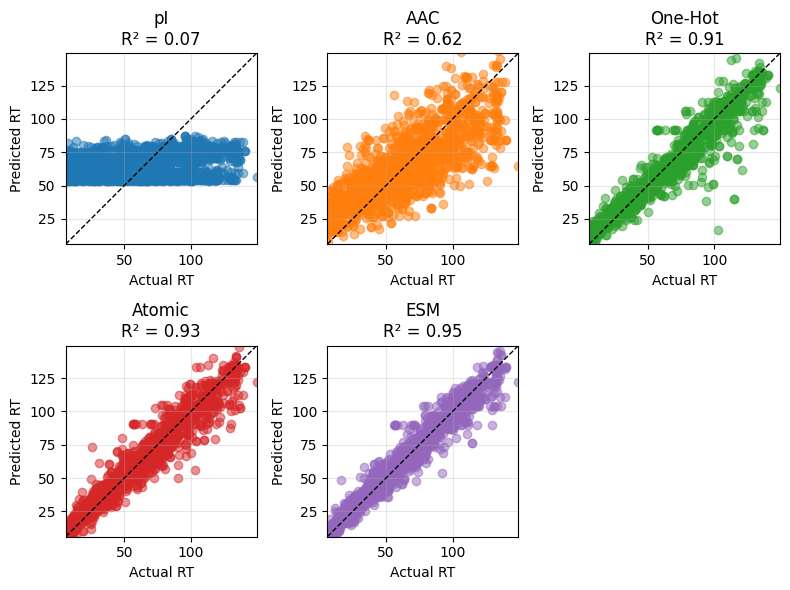

In [ ]:
# Actual vs Predicted with Subplots
fig, axes = plt.subplots(2, 3, figsize=(8, 6))  # 2 rows, 3 columns (for 5 methods)
axes = axes.ravel()  # Flatten the array of axes

# Get global min/max for consistent axis limits
all_true = np.concatenate([results[m]['true_values'] for m in methods])
global_min = all_true.min()
global_max = all_true.max()

for idx, method in enumerate(methods):
    ax = axes[idx]
    preds = results[method]['predictions']
    actual = results[method]['true_values']

    # Scatter plot
    ax.scatter(actual, preds, alpha=0.5, color=plt.cm.tab10(idx))

    # Perfect prediction line
    ax.plot([global_min, global_max], [global_min, global_max], 'k--', lw=1)

    # Add R² to title
    r2 = results[method]['test_r2']
    ax.set_title(f'{method}\nR² = {r2:.2f}', fontsize=12)
    ax.set_xlabel('Actual RT')
    ax.set_ylabel('Predicted RT')
    ax.grid(alpha=0.3)

    # Set consistent limits
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)

# Hide empty subplot
for idx in range(len(methods), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

A summary of the Actual vs. Predicted plot

* Depending on the embedding, the results are very different.
* The pI cannot correctly predict RT. It does terribly.
* A more complex embedding like ESM, even though the tensor was flattened, performs comparatively well.

In [ ]:
# Get global min/max for consistent axis limits
all_true = np.concatenate([results[m]['true_values'] for m in methods])
global_min = all_true.min()
global_max = all_true.max()

for idx, method in enumerate(methods):
    preds = results[method]['predictions']
    actual = results[method]['true_values']
    r2 = results[method]['test_r2']

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    ax.scatter(actual, preds, alpha=0.5, color=plt.cm.tab10(idx))

    # Perfect prediction line
    ax.plot([global_min, global_max], [global_min, global_max], 'k--', lw=1)

    # Titles and labels
    ax.set_title(f'{method}\nR² = {r2:.2f}', fontsize=14)
    ax.set_xlabel('Actual RT')
    ax.set_ylabel('Predicted RT')
    ax.grid(alpha=0.3)

    # Set consistent limits
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f'{method}_actual_vs_predicted.jpg', dpi=600, bbox_inches='tight')
    plt.close(fig)
    plt.show()


**Plot 3: Error box-plots**

In this plot we can compare each of the different embeding absolute error. It displays some of the same data as plot 2, but using a box plot to show the distribution of the error. Things to look for in a box plot:

* The box shows the median and interquartile range (IQR), then a whisker showing 1.5 IQR.
* Outliers are drawn as open circles, and are plotted for data points outside the whisker.
* A method could be better for having a tighter IQR, fewer outliers, a lower average error, or any combination of these metrics.

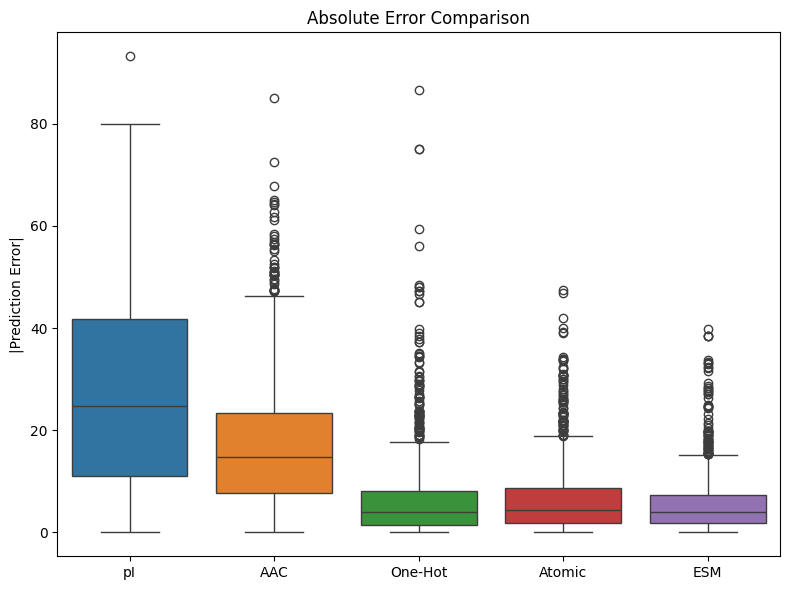

In [ ]:
# Absolute Error Comparison
abs_errors = {
    method: np.abs(results[method]['predictions'] - results[method]['true_values'])
    for method in methods
}

plt.figure(figsize=(8, 6))
sns.boxplot(data=pd.DataFrame(abs_errors), orient='v')
plt.title('Absolute Error Comparison')
plt.ylabel('|Prediction Error|')
plt.tight_layout()
plt.show()


In [ ]:
#print mean abs error for each method
for method in methods:
    print(f"{method}: {np.mean(abs_errors[method]):.2f}")


pI: 27.30
AAC: 17.15
One-Hot: 6.30
Atomic: 6.37
ESM: 5.56


Summary of error box plots
* As with other plots, methods 3, 4, and 5 all appear noticably better than methods 1 and 2.
* The ESM plot has a smaller IQR, meaning the bulk of it's answers are generally closer to correct than other methods.

**Final Caveat**
* We note that the model created in these notebooks was created with a limited amount of data and is for demonstration purposes. Training with a larger dataset (e.g. millions of peptides instead of thousands) will substantially improve the accuracy of prediction.


Thanks for reading these notebooks. If you are interested in adding to the growing library of colab notebooks for proteomics education, reach out. We'd love to hear your ideas.